In [92]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from WindPy import w
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
ldf = pd.read_excel('D:/workspace/crusader/data/list.xlsx')
ldf = ldf.dropna().set_index(u'代码')

In [4]:
DATA_DIR = 'D:/Data/industry/'
industry = [x for x in os.listdir(DATA_DIR)]

In [10]:
df = ''
for ind in industry:
    files = [f for f in os.listdir('%s/%s'%(DATA_DIR, ind))]
    for f in files:
        fname = '%s/%s/%s'%(DATA_DIR, ind, f)
        if not isinstance(df, pd.DataFrame):
            df = pd.read_excel(fname)
        else:
            tdf = pd.read_excel(fname)
            cols = tdf.columns.difference(df.columns)
            df = df.merge(tdf[cols], how='outer', left_index=True, right_index=True)

In [11]:
df = df.fillna(method='ffill').resample('BM').last()

In [12]:
df.shape

(339, 206)

In [13]:
df = df[(df.index >= '2004-01-01') & (df.index <= '2018-02-28')]

In [14]:
df = df.dropna(axis=1)

In [15]:
df.shape

(170, 114)

In [16]:
INDEX_DIR = 'D:/Data/index'

In [17]:
dic = {}
for f in os.listdir(INDEX_DIR):
    if f.startswith('881') or f.startswith('886'):
        fname = '%s/%s'%(INDEX_DIR, f)
        temp = pd.read_excel(fname)
        dic[f.rstrip('.xlsx')] = temp['close']
sdf = pd.DataFrame(dic)

In [18]:
rdf = sdf.resample('BM').last().pct_change()

In [19]:
rdf = rdf[(rdf.index >= '2004-01-01') & (rdf.index <= '2018-02-28')]

In [20]:
fea = pd.DataFrame(index=df.index, columns=df.columns)
for date in df.index:
    past = df[df.index <= date][-60:] # 过去5年
    fea.loc[date] = (df.loc[date] - past.mean()) / past.std()

In [21]:
fea = fea[fea.index >= '2006-01-01']
rdf = rdf[rdf.index >= '2006-01-01']

# 特征筛选

In [195]:
code = '886005.WI'
acc_ret = rdf[code] - rdf['881001.WI']

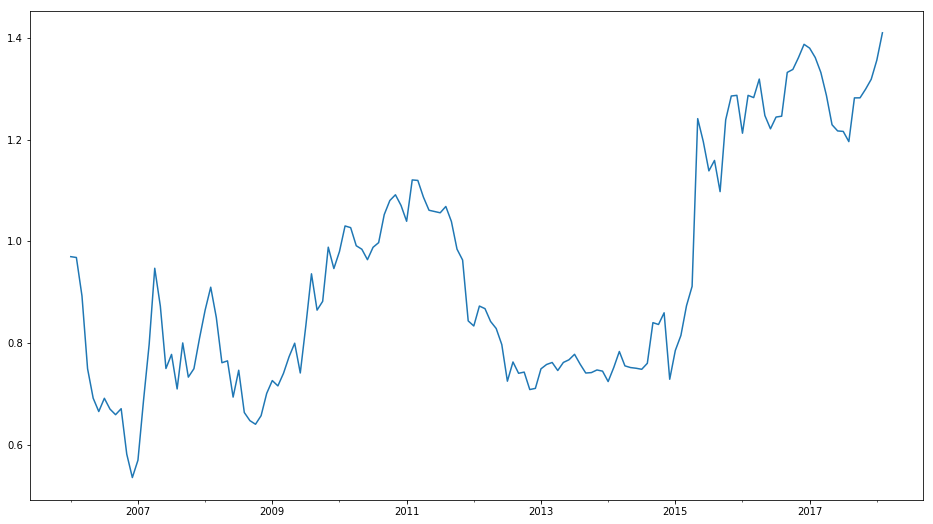

In [196]:
nav = (1 + acc_ret).cumprod()
nav.plot(figsize=(16, 9))

In [197]:
lasso = linear_model.Lasso(alpha=0.01)

In [198]:
lasso.fit(fea, acc_ret)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [199]:
lasso.coef_

array([ 0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.00154068,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        , -0.        , -0.00235999, -0.        ,  0.        ,
       -0.        ,  0.        , -0.00267222, -0.        , -0.        ,
        0.        , -0.        ,  0.        , -0.00047984, -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.0028644 , -0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.  

In [200]:
ldf.loc[fea.columns[lasso.coef_ != 0]]

,名称
代码,
M0009812,1年期贷款基准利率
S0073293,房地产新开工施工面积增速
S0073293,房地产新开工面积
S0073293,房地产新开工施工面积增速
S0073293,房地产新开工面积
S0073293,中国房地产新开工面积
S0027367,铁矿石原矿量产量
S0027078,尿素产量
S0048337,发电累计耗用原煤


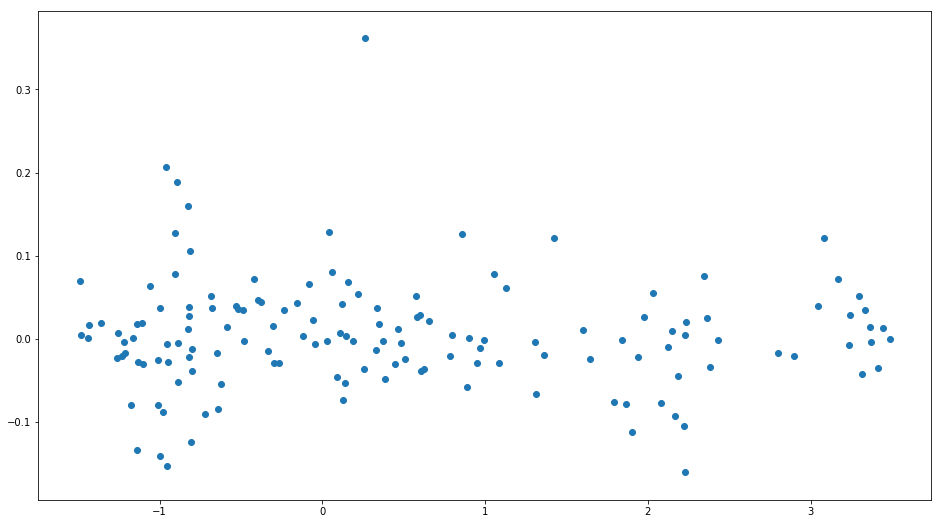

In [201]:
plt.figure(figsize=(16, 9))
plt.scatter(fea['S0049494'], acc_ret)

# 一段时间的均值观察相关关系

In [202]:
K = 3
fea_roll = fea.rolling(window=K).mean().dropna()
acc_ret_roll = acc_ret.rolling(window=K).mean().dropna()

In [203]:
lasso = linear_model.Lasso(alpha=0.01)

In [204]:
lasso.fit(fea_roll, acc_ret_roll)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [205]:
ldf.loc[fea.columns[lasso.coef_ != 0]]

,名称
代码,
S0073293,房地产新开工施工面积增速
S0073293,房地产新开工面积
S0073293,房地产新开工施工面积增速
S0073293,房地产新开工面积
S0073293,中国房地产新开工面积
S5111905,布伦特原油现货价
S0073297,房地产竣工面积
M0055579,苏州商品房销售面积


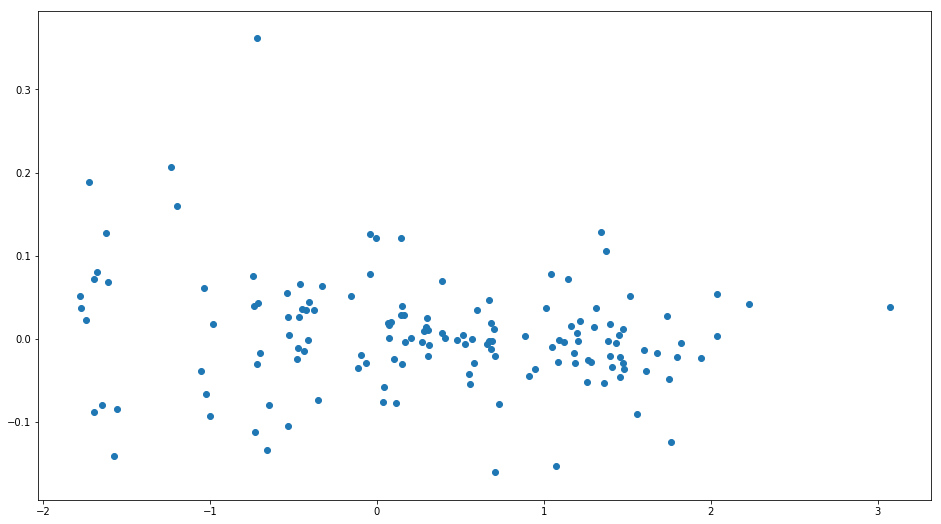

In [206]:
plt.figure(figsize=(16, 9))
plt.scatter(fea['S0048337'], acc_ret)

In [207]:
pred_ret = lasso.predict(fea_roll)

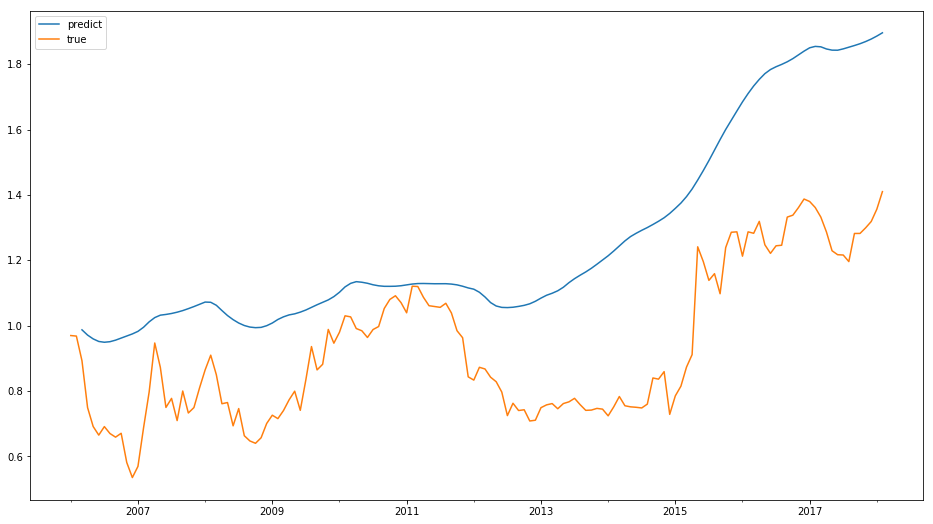

In [208]:
plt.figure(figsize=(16, 9))
# plt.plot((1 + pred_ret).cumprod())
pd.Series((1 + pred_ret).cumprod(), index=acc_ret_roll.index).plot(figsize=(16, 9), label='predict')
(1 + acc_ret).cumprod().plot(figsize=(16, 9), label='true')
plt.legend()

# 滚动训练

In [209]:
pred_ret = pd.Series(index=acc_ret_roll.index)
window = 24
for date in fea_roll.index:
    past_fea = fea_roll[fea_roll.index <= date][-window:]
    past_ret = acc_ret_roll[acc_ret_roll.index <= date][-window:]
    if past_fea.shape[0] == window:
#         print past_ret.shape, past_fea.shape
        lasso = linear_model.Lasso(alpha=0.01)
        lasso.fit(past_fea, past_ret)
        pred_ret.loc[date] = lasso.predict([fea_roll.loc[date]])[0]

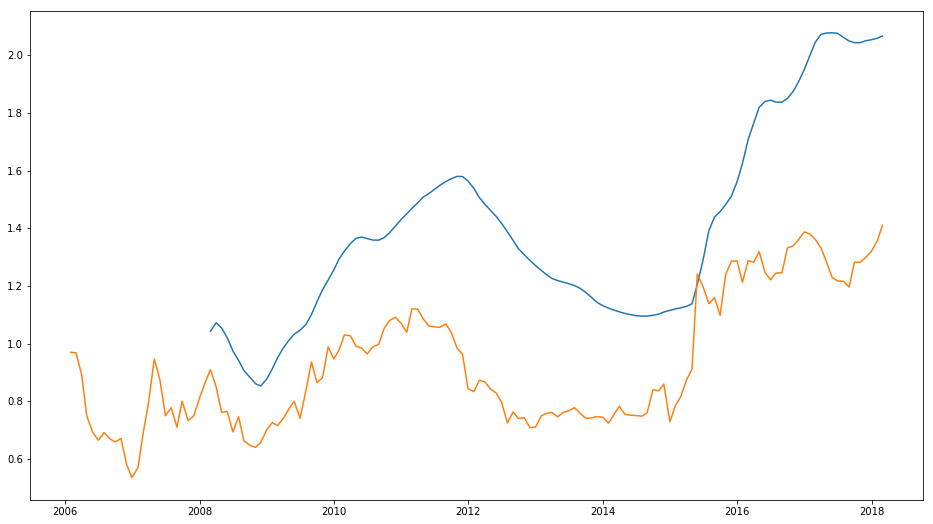

In [210]:
plt.figure(figsize=(16, 9))
plt.plot((1 + pred_ret).cumprod())
plt.plot((1 + acc_ret).cumprod())